# Mean reverting strategy based on Bollinger bands Strategy

This notebook answers question 3.5 form the text book Advances in Financial Machine Learning.

3.5 Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [0, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Use as features: volatility, seial correlation, and teh crossinmg moving averages.
* (c) What is teh accuracy of prediction from the primary model? (i.e. if the secondary model does not filter the bets) What are the precision, recall and FI-scores?
* (d) What is teh accuracy of prediction from the primary model? What are the precision, recall and FI-scores?


In [138]:
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

from mlfinlab.corefns.core_functions import CoreFunctions
from mlfinlab.corefns.financial_functions import FinancialFunctions
from mlfinlab.fracdiff.fracdiff import frac_diff_ffd, compute_differencing_amt 

import matplotlib.pyplot as plt
%matplotlib inline

### Read in Data
We are using the dollar bars based off of the high quality HFT data we purchased. There is a sample of bars available in this branch as well. 

In [139]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [140]:
data = data['2011-09-01':'2018-01-01']

---
### Define helper functions

In [141]:
# Compute RSI
def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = FinancialFunctions.relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

---
### Fit a Primary Model: Mean-reverting based on Bollinger bands
Based on the mean-reverting Bollinger band strategy.


In [142]:
# compute bands
window = 50
data['avg'], data['upper'], data['lower'] = FinancialFunctions.bbands(data['close'], window, no_of_stdev=1.5)
data.sample(10)

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower
date_time,,,,,,,,,,
2017-12-19 20:23:24.848,2683.75,2687.75,2683.50,2687.25,26123,70156464.50,2912,2689.535431,2697.954683,2681.116178
2015-03-26 13:07:48.248,2038.50,2045.75,2038.25,2045.50,34267,70002483.25,4998,2059.435813,2084.400458,2034.471168
2013-02-06 13:40:39.700,1501.50,1502.50,1500.50,1500.50,46627,70009901.50,11565,1504.113958,1511.309803,1496.918113
2014-01-10 15:01:00.359,1835.00,1835.25,1830.75,1831.00,38208,70043140.50,10075,1833.058821,1838.693606,1827.424037
2013-08-27 14:03:48.823,1642.00,1643.75,1640.75,1640.75,42625,70002344.50,11478,1651.443947,1665.855013,1637.032880
2013-05-29 17:50:55.280,1648.00,1649.75,1647.50,1649.50,42461,70000896.00,11923,1647.936446,1658.980000,1636.892892
2013-09-09 14:01:47.611,1663.50,1665.25,1663.50,1664.50,42063,70005584.50,10543,1656.980487,1664.929711,1649.031263
2011-09-25 22:37:01.708,1127.75,1144.50,1122.00,1143.25,61983,70047246.75,14597,1126.478490,1138.075459,1114.881520
2014-01-17 20:59:59.801,1831.00,1833.00,1830.75,1832.25,38207,70008464.50,4666,1836.135675,1842.122315,1830.149035


In [143]:
### Compute fractional differencing
diff_amt = compute_differencing_amt(data['close'])
print('Differening amount: {:.3f}'.format(diff_amt))
fracs = frac_diff_ffd(data['close'].apply(np.log), differencing_amt=diff_amt, threshold=1e-5)

Differening amount: 0.010


In [144]:
frac_df = pd.Series(data=fracs, index=data.index)
frac_df.tail()
data['fracdiff'] = [frac_df[x] for x in data.index]

In [145]:
# Compute RSI
rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

---
### Fit a Primary Model: Bollinger Band Mean-Reversion

In [146]:
# Compute sides
data['side'] = np.nan

# long_signals = (data['close'] <= data['lower']) & (data['rsi'] <= 25)
# short_signals = (data['close'] >= data['upper']) & (data['rsi'] >= 75) 

long_signals = (data['close'] <= data['lower']) 
short_signals = (data['close'] >= data['upper']) 

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())
# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

 1.0    3306
-1.0    3280
Name: side, dtype: int64


In [147]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [148]:
print(data.side.value_counts())

 1.0    3306
-1.0    3280
Name: side, dtype: int64


### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [149]:
# Compute daily volatility
daily_vol = CoreFunctions.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = CoreFunctions.get_t_events(data['close'], threshold=daily_vol.mean() * 0.1)

# Compute vertical barrier
vertical_barriers = CoreFunctions.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

Calculating daily volatility for dynamic thresholds
Applying Symmetric CUSUM filter.


100%|█████████████████████████████████████████████████████████████████████████████████| 6584/6584 [00:00<00:00, 7259.02it/s]


In [150]:
pt_sl = [0, 2]
min_ret = 0.0005
triple_barrier_events = CoreFunctions.get_events(close=data['close'],
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=data['side'])

D:\Documents\WQU\Courses\14 - Capstone 690\chap3\research\Chapter3\mlfinlab\corefns\core_functions.py:205: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-03-10 17:51:21.006076 100.0% apply_pt_sl_on_t1 done after 0.09 minutes. Remaining 0.0 minutes.


In [151]:
labels = CoreFunctions.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

 1.0    1937
-1.0    1696
Name: side, dtype: int64

---
### Results of Primary Model:
What is the accuracy of predictions from the primary model (i.e., if the secondary model does not filter the bets)? Compute the precision, recall, and F1-scores?

In [152]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

c:\users\asingh\anaconda3\envs\cap\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2951
           1       0.19      1.00      0.32       682

   micro avg       0.19      0.19      0.19      3633
   macro avg       0.09      0.50      0.16      3633
weighted avg       0.04      0.19      0.06      3633

Confusion Matrix
[[   0 2951]
 [   0  682]]

Accuracy
0.18772364437104322


In [153]:
# a few takeaways - 
# 1. there is an imbalance in the classes - far more are classified as "no trade"
# 2. meta-labeling says that there are many false-positives  

# the sklearn's confusion matrix is [[TN, FP][FN, TP]] 

---
## Fit a Meta Model
Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

Create the following features: 
* Volatility
* Serial Correlation
* The returns at the different lags from the serial correlation
* The sides from the SMavg Strategy

In [154]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,fracdiff,rsi,side
date_time,,,,,,,,,,,,,
2011-09-01 14:06:29.252,1227.50,1228.50,1223.25,1225.00,57108,70001176.25,17120,1218.912702,1228.025966,1209.799438,0.0,66.0,NaN
2011-09-01 14:11:19.584,1225.00,1226.50,1223.00,1224.25,57151,70000669.00,18100,1219.376556,1228.371993,1210.381118,0.0,65.0,NaN
2011-09-01 14:15:02.734,1224.25,1224.75,1219.25,1219.75,57307,70010132.75,16844,1219.407534,1228.004684,1210.810383,0.0,51.0,NaN
2011-09-01 14:19:45.128,1219.50,1221.50,1218.00,1221.00,57382,70000958.25,16802,1219.534096,1227.793911,1211.274282,0.0,47.0,NaN
2011-09-01 14:28:51.391,1221.00,1223.75,1220.50,1221.75,57280,70004186.50,16969,1219.703391,1227.680223,1211.726559,0.0,55.0,NaN


### Features

In [155]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()


In [156]:
# Add Trending signals
raw_data['sma'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'sma'] = -1

In [157]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['close'] <= raw_data['lower'] 
short_signals = raw_data['close'] >= raw_data['upper'] 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [158]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Now get the data at the specified events

In [159]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['fracdiff', 'avg', 'upper', 'lower', 'open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']
X.head()

,rsi,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,sma
2011-09-05 14:12:23.480,9.0,1.0,-0.002602,-0.002599,-0.008396,-0.009036,-0.016652,-0.017701,0.002420,0.081803,0.089604,0.105046,-0.031726,0.103004,-0.005830,-0.000646,-0.007715,-0.001067,0.000000,-1.0
2011-09-05 15:22:54.484,5.0,1.0,-0.008503,-0.008467,-0.011044,-0.016792,-0.017427,-0.024979,0.002629,0.133147,0.202646,0.098246,0.169494,0.100294,-0.002602,-0.005830,-0.000646,-0.007715,-0.001067,-1.0
2011-09-06 02:10:47.714,5.0,1.0,0.005023,0.005036,-0.003474,-0.006063,-0.011841,-0.012478,0.002748,-0.014636,0.156579,-0.018503,0.170098,-0.032270,-0.008503,-0.002602,-0.005830,-0.000646,-0.007715,-1.0
2011-09-06 07:07:37.112,5.0,1.0,-0.004805,-0.004793,0.000219,-0.008250,-0.010827,-0.016577,0.002801,-0.074770,0.218655,0.001445,0.221540,-0.033719,0.005023,-0.008503,-0.002602,-0.005830,-0.000646,-1.0
2011-09-09 13:34:20.611,12.0,1.0,-0.005135,-0.005122,-0.006182,-0.009771,-0.011241,-0.015209,0.002408,0.113521,-0.138582,0.169341,0.087514,0.110834,-0.001066,-0.003617,-0.001486,-0.004022,-0.001478,-1.0


### Fit a model

In [160]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [161]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()
# print(X_train['side'].isnull().sum().sum())
# X_train.isna().any()

0    2371
1     535
Name: bin, dtype: int64

In [162]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    2371
0    2371
Name: bin, dtype: int64

In [163]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']
X_train.isnull().sum().sum()

0

In [164]:
# Random Forest Model
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

n_estimator = 1000
c_random_state = 42
depth = 2

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Training Metrics

              precision    recall  f1-score   support

           0       0.61      0.63      0.62      2371
           1       0.62      0.60      0.61      2371

   micro avg       0.61      0.61      0.61      4742
   macro avg       0.61      0.61      0.61      4742
weighted avg       0.61      0.61      0.61      4742

Confusion Matrix
[[1497  874]
 [ 954 1417]]

Accuracy
0.6145086461408689


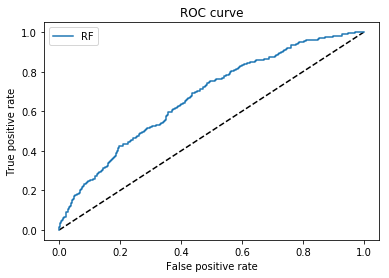

In [165]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Test Metrics

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       580
           1       0.36      0.39      0.38       147

   micro avg       0.73      0.73      0.73       727
   macro avg       0.60      0.61      0.60       727
weighted avg       0.74      0.73      0.74       727

Confusion Matrix
[[476 104]
 [ 89  58]]

Accuracy
0.734525447042641


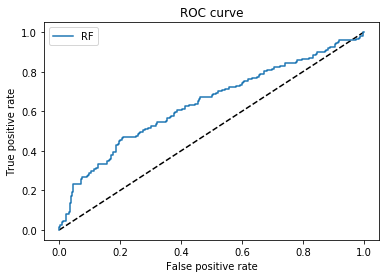

In [166]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

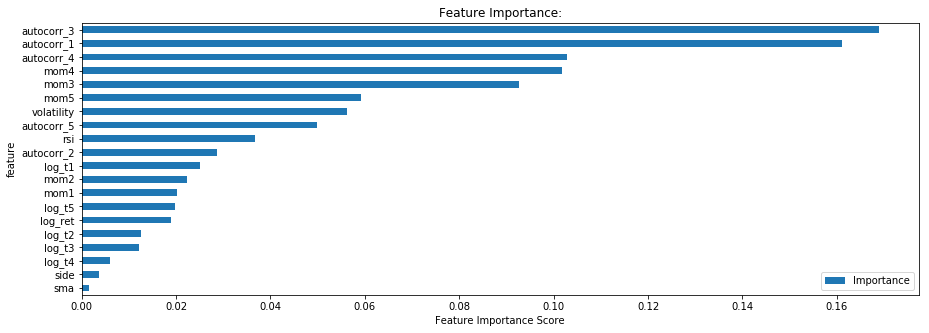

In [167]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

Note how low the side is ranked.

---
## Performance Tear Sheets

Start date,2016-07-29
End date,2017-12-27
Total months,34
,Backtest
Annual return,57.9%
Cumulative returns,273.5%
Annual volatility,15.3%
Sharpe ratio,3.05
Calmar ratio,2.45
Stability,0.90
Max drawdown,-23.6%


c:\users\asingh\anaconda3\envs\cap\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.64,2016-11-01,2016-11-09,2016-11-09,6
1,14.48,2016-09-01,2016-09-09,2016-10-04,24
2,14.31,2016-11-14,2016-12-13,2017-03-27,96
3,13.92,2017-05-15,2017-05-25,2017-06-29,34
4,10.12,2017-08-08,2017-08-17,2017-09-25,34


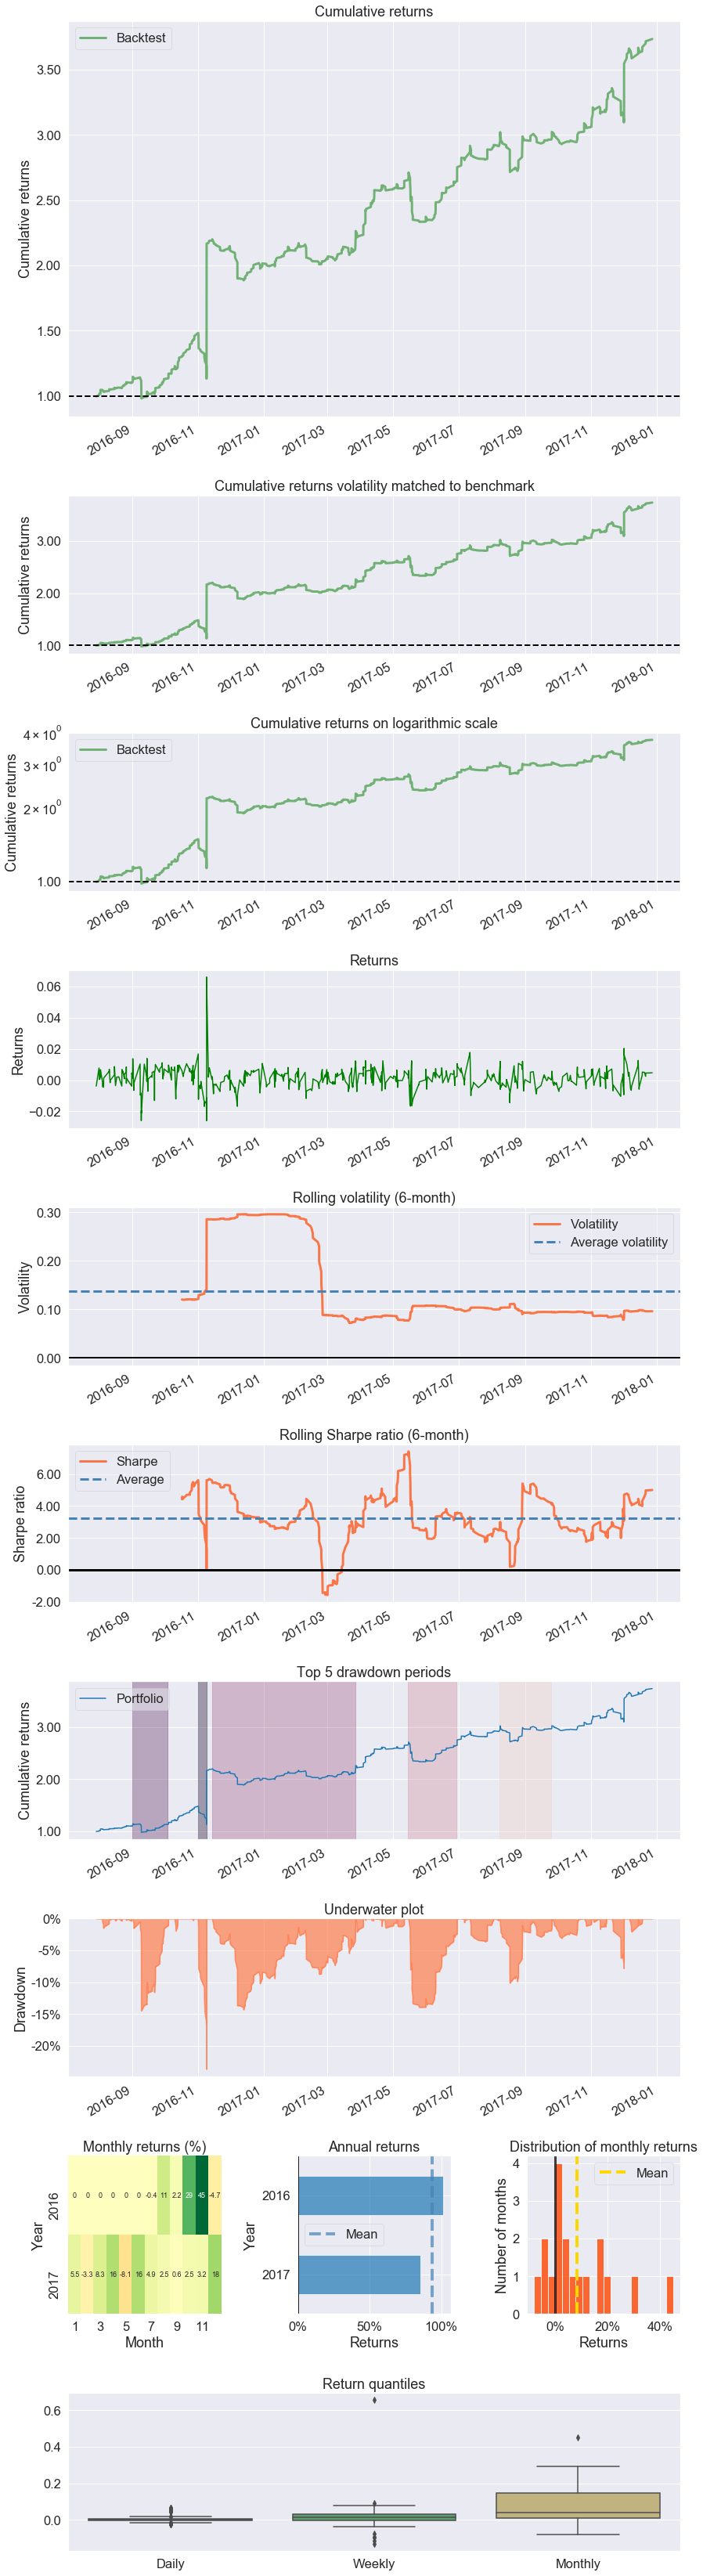

In [168]:
test_dates = X_test.index
pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)

Start date,2016-07-29
End date,2017-12-27
Total months,34
,Backtest
Annual return,43.9%
Cumulative returns,185.8%
Annual volatility,12.9%
Sharpe ratio,2.90
Calmar ratio,3.58
Stability,0.81
Max drawdown,-12.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.27,2016-09-08,2016-09-09,2016-10-13,26
1,7.26,2016-11-01,2016-11-09,2016-11-09,6
2,1.97,2017-05-15,2017-05-17,2017-06-09,20
3,1.78,2017-11-30,2017-12-01,2017-12-01,1
4,1.41,2017-03-03,2017-03-24,2017-03-27,16


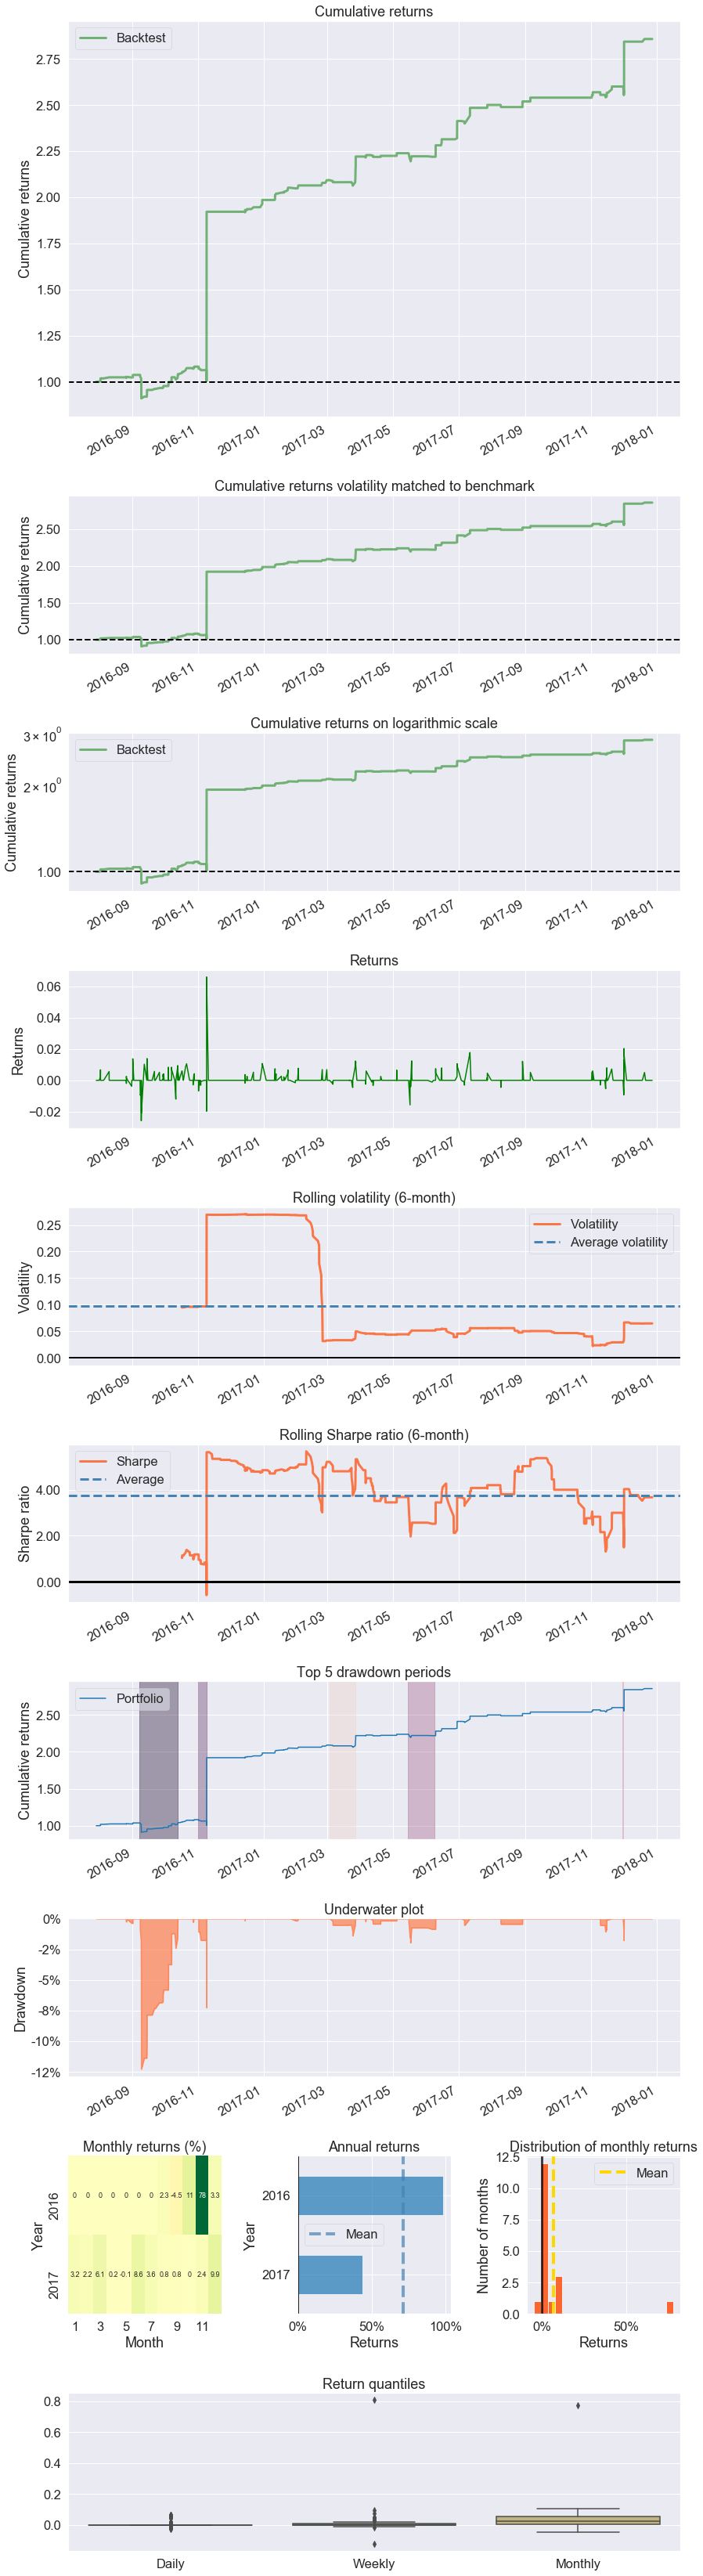

In [169]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)

---
### Use PCA to shrink the predictor space

In [170]:
# standardize the data
scaler = StandardScaler()

# fit the training set only
scaler.fit(X_train)

# Apply the transform to both training and test sets
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# make an instance of the PCA model with 95% coverage
pca = PCA(0.9)

# fit teh PCA model
pca.fit(X_train_std)
print(pca.n_components_)

# transform both training and test sets
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

11


In [171]:
# Apply RF 
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train_pca, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Training Metrics (PCA)

              precision    recall  f1-score   support

           0       0.64      0.60      0.61      2371
           1       0.62      0.66      0.64      2371

   micro avg       0.63      0.63      0.63      4742
   macro avg       0.63      0.63      0.63      4742
weighted avg       0.63      0.63      0.63      4742

Confusion Matrix
[[1411  960]
 [ 810 1561]]

Accuracy
0.6267397722479966


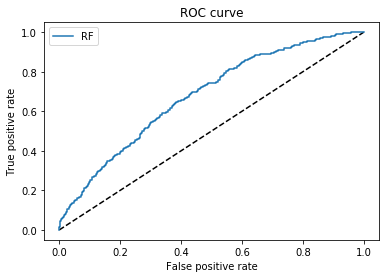

In [172]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train_pca)[:, 1]
y_pred = rf.predict(X_train_pca)

fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Test Metrics (PCA)

              precision    recall  f1-score   support

           0       0.82      0.64      0.72       580
           1       0.24      0.44      0.31       147

   micro avg       0.60      0.60      0.60       727
   macro avg       0.53      0.54      0.51       727
weighted avg       0.70      0.60      0.64       727

Confusion Matrix
[[372 208]
 [ 82  65]]

Accuracy
0.6011004126547456


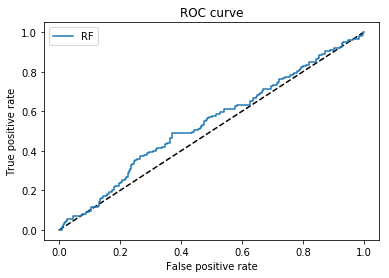

In [173]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test_pca)[:, 1]
y_pred = rf.predict(X_test_pca)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

---
## Performance Tear Sheets

c:\users\asingh\anaconda3\envs\cap\lib\site-packages\pyfolio\tears.py:514: UserWarning: The latest version of pyfolio requires users to supply benchmark returns. Your current tearsheets will not include plots and analyses that require a benchmark. In the future, please pass benchmark_rets, or pass None to silence this warning.
  warnings.warn(BENCHMARK_RETS_WARNING)


Start date,2016-07-29
End date,2017-12-27
Total months,34
,Backtest
Annual return,57.9%
Cumulative returns,273.5%
Annual volatility,15.3%
Sharpe ratio,3.05
Calmar ratio,2.45
Stability,0.90
Max drawdown,-23.6%


c:\users\asingh\anaconda3\envs\cap\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.64,2016-11-01,2016-11-09,2016-11-09,6
1,14.48,2016-09-01,2016-09-09,2016-10-04,24
2,14.31,2016-11-14,2016-12-13,2017-03-27,96
3,13.92,2017-05-15,2017-05-25,2017-06-29,34
4,10.12,2017-08-08,2017-08-17,2017-09-25,34


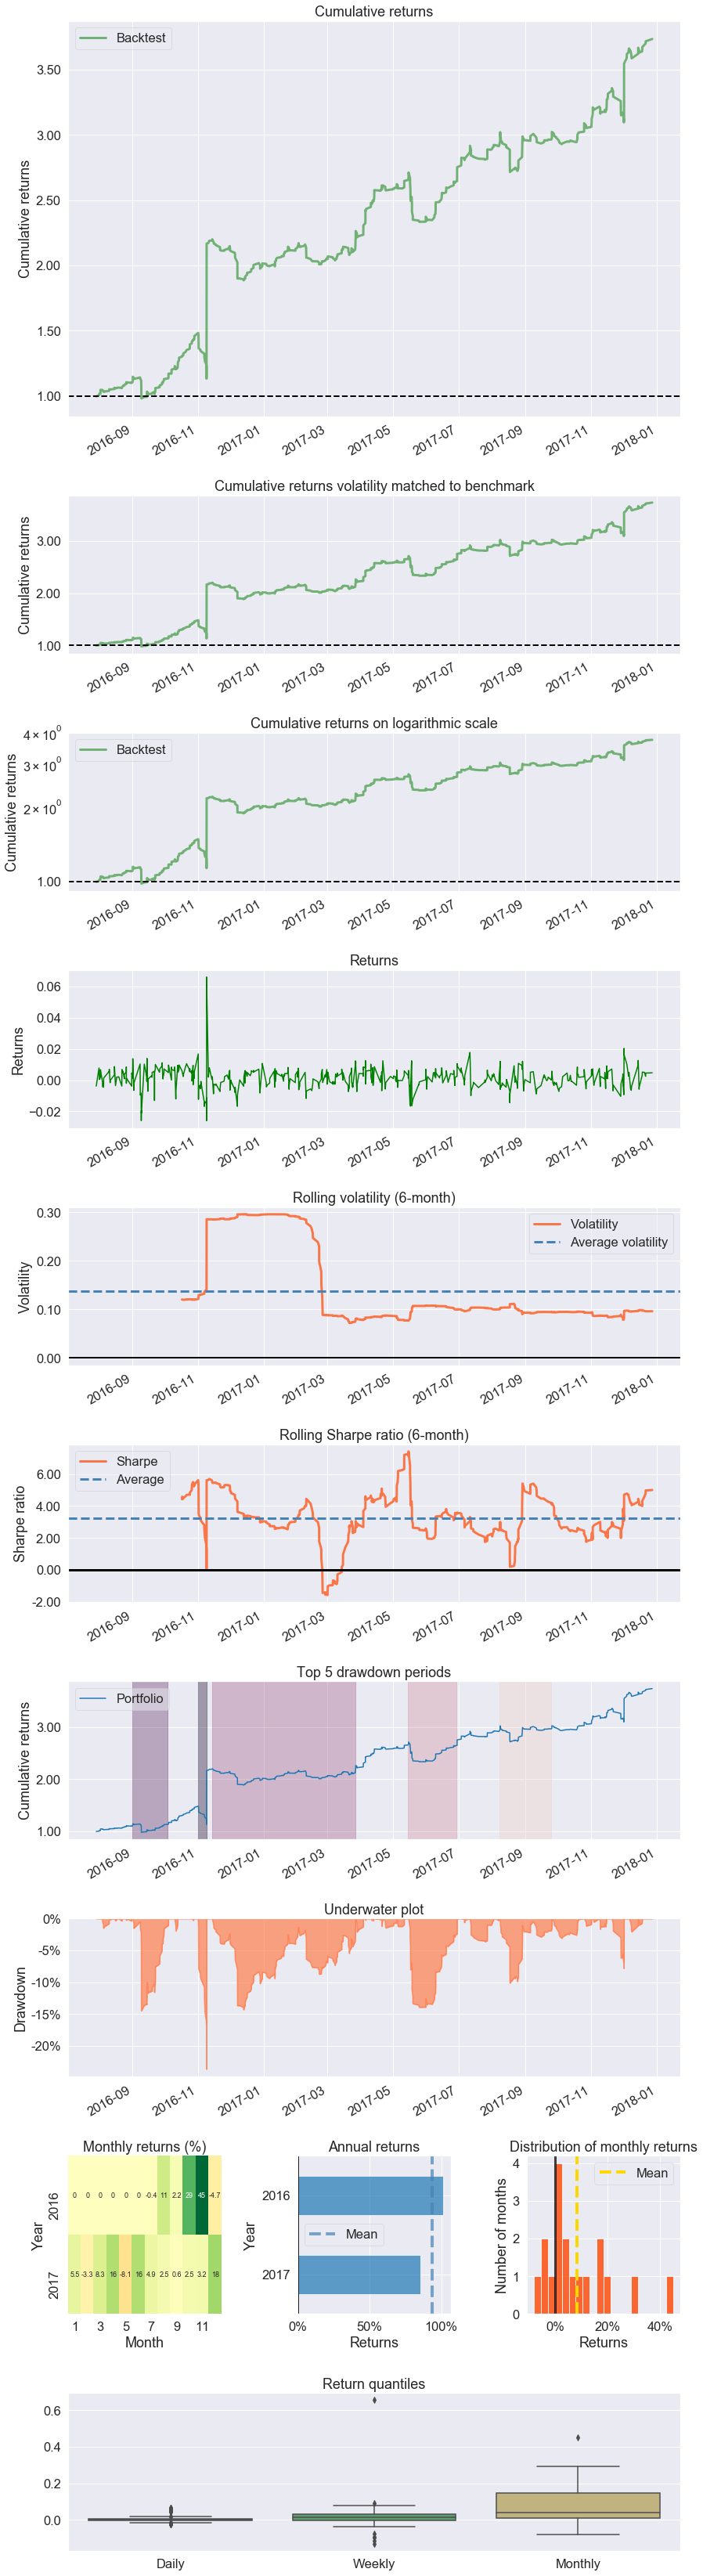

None


In [174]:
test_dates = X_test.index
print(pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret']))

Start date,2016-07-29
End date,2017-12-27
Total months,34
,Backtest
Annual return,22.4%
Cumulative returns,79.2%
Annual volatility,9.6%
Sharpe ratio,2.16
Calmar ratio,1.60
Stability,0.92
Max drawdown,-14.1%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.05,2016-09-08,2016-09-09,2016-10-10,23
1,10.67,2016-11-01,2016-11-09,2016-11-09,6
2,5.94,2017-02-08,2017-03-24,2017-05-04,62
3,3.70,2017-05-15,2017-05-18,2017-06-15,23
4,2.69,2017-11-28,2017-12-01,2017-12-01,4


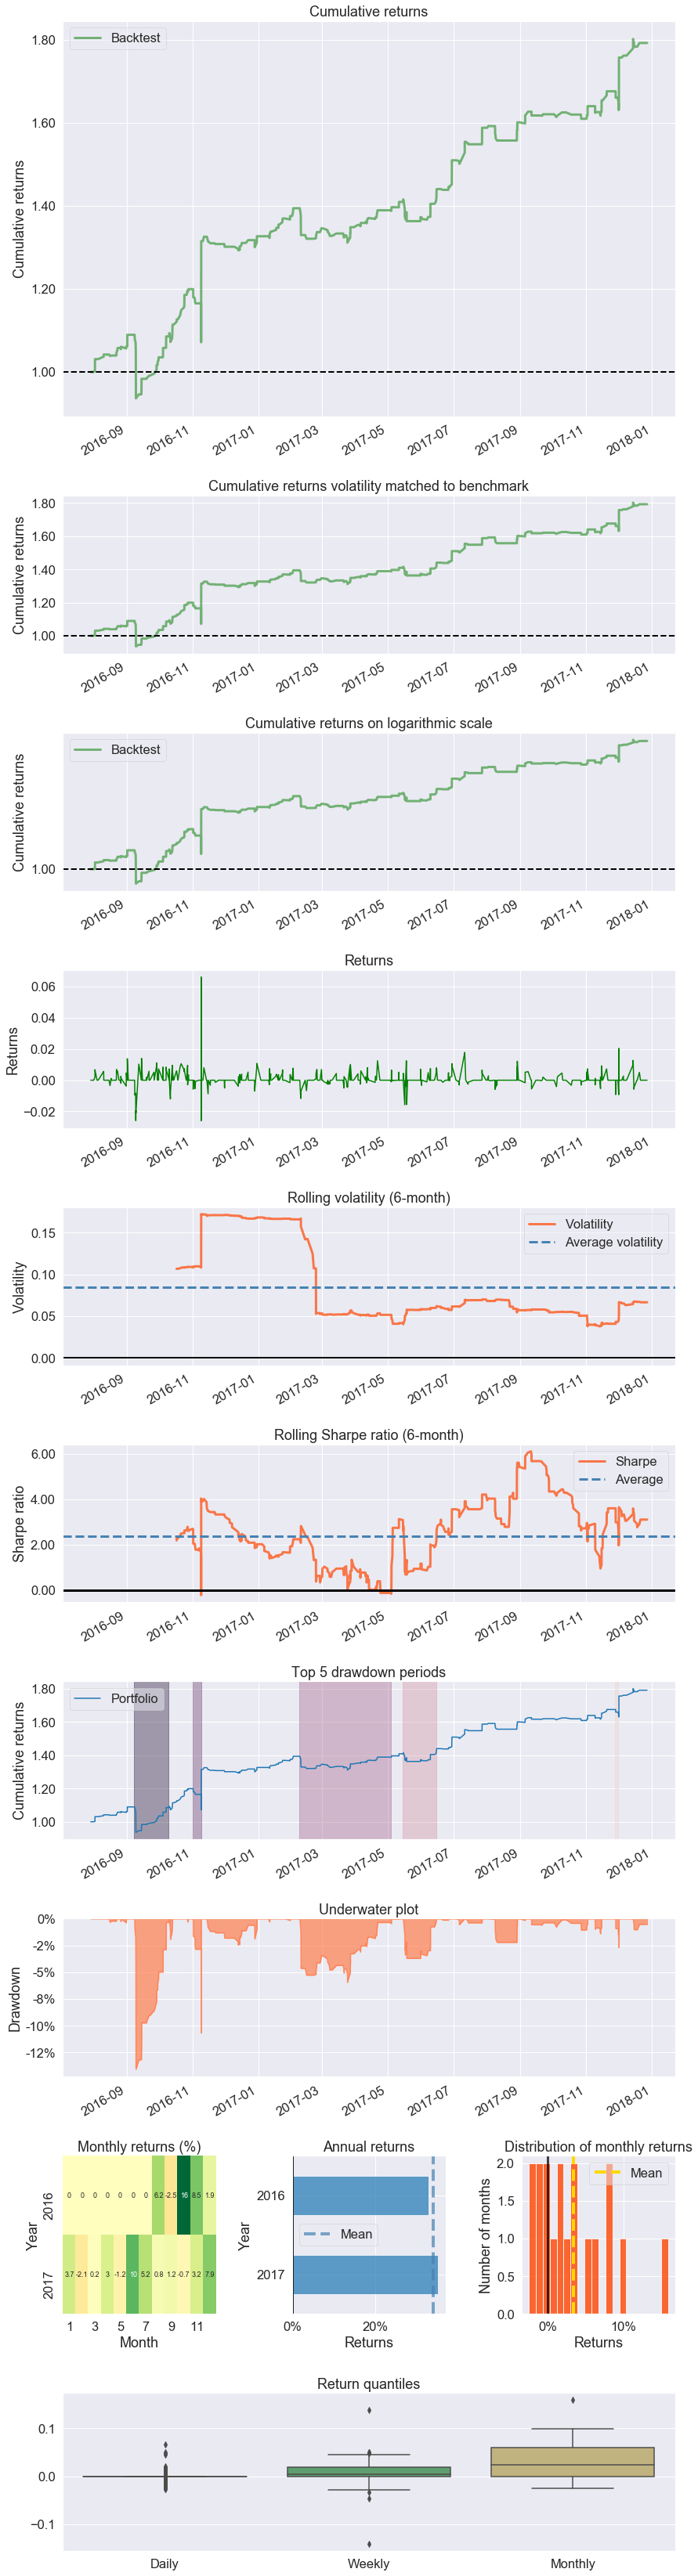

None


In [175]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
print(pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None))

---
## Conclusion
We observe that in case of Bollinger bands mean-reverting strategy, the meta-labeling process looses some upside (lower annualized return 44% v. 58%) but helps reduce the risk in the strategy compred to teh primary model. The maximum drawdown falls from 24% to 12.3%.  The volatility of the returns are lower as well (13% compared to 15.2%).  The net result is that Sharpe ratio of meta-model (2.90) is is not too different from that of the primary model (3.05). We also ran a PCA variant of the same strategy to reduce the number of dimensions. The result shows that when PCA captures 90% of the variance, the annualized return falls to 22.4% at 9.5% annualized volatility and a Sharpe of 2.16.     